# Import packages

In [7]:
!pip install -qU newsapi-python
!pip install -qU vaderSentiment
!pip install -qU yfinance
!pip install -qU alpaca-py

In [8]:
# !pip install black[jupyter]
## run source activate python3
## black Backtesting_Framework.ipynb in terminal

In [9]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from abc import ABCMeta, abstractmethod
import requests
from pandas.tseries.offsets import BDay
from newsapi import NewsApiClient
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import boto3
from botocore.exceptions import ClientError
import json

%matplotlib inline

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/seaborn/_statistics.py:32: UserWarning: A NumPy version >=1.23.5 and <2.3.0 is required for this version of SciPy (detected version 1.22.4)
  from scipy.stats import gaussian_kde


# Dataloader

In [10]:
## Load from Alpaca
class DataLoader:
    def __init__(self, stock_client):
        self.stock_client = stock_client
        
    def fetch_historical_data(self, symbol, start_date=None, end_date=None):
        request_params = StockBarsRequest(
                                symbol_or_symbols=[symbol],
                                timeframe=TimeFrame.Day,
                                start=start_date
                        )
        bars_df = self.stock_client.get_stock_bars(request_params).df

        bars_df = (
            bars_df[['open', 'high', 'low', 'close', 'volume']]
            .reset_index().drop('symbol', axis=1)
        )

        bars = (
            bars_df
            .set_index(keys='timestamp', drop=True)
            .rename(columns={
                'open': 'Open', 
                'high': 'High', 
                'low': 'Low', 
                'close': 'Close', 
                'volume': 'Volume'
                })
        )
        
        # print(bars.index[0].date())
        # print(type(bars.index[0]))
        # bars.index = bars.index.strftime('%Y-%m-%d')
        bars.index = [i.date() for i in bars.index]
        bars.index.name = 'Date'

        return bars
        # return bars_df

In [11]:
# DataLoader(client).fetch_historical_data(symbol, start_date)

# Abstract classes

## Strategy

In [12]:
class Strategy(object):
    """Strategy is an abstract base class providing an interface for
    all subsequent (inherited) trading strategies.

    The goal of a (derived) Strategy object is to output a list of signals,
    which has the form of a time series indexed pandas DataFrame.

    In this instance only a single symbol/instrument is supported."""

    __metaclass__ = ABCMeta

    @abstractmethod
    def generate_signals(self):
        """An implementation is required to return the DataFrame of symbols
        containing the signals to go long, short or hold (1, -1 or 0)."""
        raise NotImplementedError("Should implement generate_signals()!")

## Portfolio

In [13]:
class Portfolio(object):
    """An abstract base class representing a portfolio of
    positions (including both instruments and cash), determined
    on the basis of a set of signals provided by a Strategy."""

    __metaclass__ = ABCMeta

    @abstractmethod
    def generate_positions(self):
        """Provides the logic to determine how the portfolio
        positions are allocated on the basis of forecasting
        signals and available cash."""
        raise NotImplementedError("Should implement generate_positions()!")

    @abstractmethod
    def backtest_portfolio(self):
        """Provides the logic to generate the trading orders
        and subsequent equity curve (i.e. growth of total equity),
        as a sum of holdings and cash, and the bar-period returns
        associated with this curve based on the 'positions' DataFrame.

        Produces a portfolio object that can be examined by
        other classes/functions."""
        raise NotImplementedError("Should implement backtest_portfolio()!")

# Strategy subclasses

## Random Strategy

In [14]:
class RandomForecastingStrategy(Strategy):
    """Derives from Strategy to produce a set of signals that
    are randomly generated long/shorts. Clearly a nonsensical
    strategy, but perfectly acceptable for demonstrating the
    backtesting infrastructure!"""

    def __init__(self, symbol, bars):
        """Requires the symbol ticker and the pandas DataFrame of bars"""
        self.symbol = symbol
        self.bars = bars

    def generate_signals(self):
        """Creates a pandas DataFrame of random signals."""
        signals = pd.DataFrame(index=self.bars.index)
        signals["signal"] = np.sign(np.random.randn(len(signals)))

        # The first five elements are set to zero in order to minimise
        # upstream NaN errors in the forecaster.
        signals["signal"][0:5] = 0.0
        return signals

## MovingAverageCrossStrategy

In [15]:
class MovingAverageCrossStrategy(Strategy):
    def __init__(self, symbol, bars, short_window=2, long_window=5):
        self.symbol = symbol
        self.bars = bars
        self.short_window = short_window
        self.long_window = long_window

    def generate_signals(self):
        signals = pd.DataFrame(index=self.bars.index)
        signals["signal"] = 0.0

        signals["short_mavg"] = (
            self.bars["Close"].rolling(self.short_window, min_periods=1).mean()
        )
        signals["long_mavg"] = (
            self.bars["Close"].rolling(self.long_window, min_periods=1).mean()
        )

        # print(signals['short_mavg'][self.short_window:].shift(1) < signals['long_mavg'][self.short_window:].shift(1))

        
        signals["signal"][self.short_window :] = np.where(
            (
                (
                    signals["short_mavg"][self.short_window :]
                    > signals["long_mavg"][self.short_window :]
                )
                & (
                    signals["short_mavg"][self.short_window :].shift(1)
                    < signals["long_mavg"][self.short_window :].shift(1)
                )
            ),
            1.0,
            0.0,
        )

        signals["signal"][self.short_window :] = np.where(
            (
                (
                    signals["short_mavg"][self.short_window :]
                    < signals["long_mavg"][self.short_window :]
                )
                & (
                    signals["short_mavg"][self.short_window :].shift(1)
                    > signals["long_mavg"][self.short_window :].shift(1)
                )
            ),
            -1.0,
            signals["signal"][self.short_window:],
        )

        # # signals['positions'] = signals['signal'].diff()
        # signals['positions'] = signals['signal'].cumsum()

        return signals

## Sentiment Analysis Strategy

### TradingDateCalculator

In [16]:
class TradingDateCalculator:
    @staticmethod
    def get_trade_open(date):
        curr_date_open = pd.to_datetime(date).floor("d").replace(
            hour=13, minute=30
        ) - BDay(0)
        curr_date_close = pd.to_datetime(date).floor("d").replace(
            hour=20, minute=0
        ) - BDay(0)

        prev_date_close = (curr_date_open - BDay()).replace(hour=20, minute=0)
        next_date_open = (curr_date_close + BDay()).replace(hour=13, minute=30)

        if (pd.to_datetime(date) >= prev_date_close) & (
            pd.to_datetime(date) < curr_date_open
        ):
            return curr_date_open
        elif (pd.to_datetime(date) >= curr_date_close) & (
            pd.to_datetime(date) < next_date_open
        ):
            return next_date_open
        else:
            return None


class NewsLoader:
    def __init__(self, news_api_key):
        self.news_api_key = news_api_key
        self.url = "https://newsapi.org/v2/everything?"

    def load_news(self, symbol, pageSize=100):  # Timeframe,
        parameters = {
            "q": symbol,
            "sortBy": "popularity",
            "pageSize": pageSize,
            "apiKey": self.news_api_key,
        }

        response = requests.get(self.url, params=parameters)
        data = pd.DataFrame(response.json())

        # Transformation to data for use
        news_df = pd.concat([data["articles"].apply(pd.Series)], axis=1)

        # This is sentiment analysi regarding to headlines
        final_news = news_df[["publishedAt", "title"]].copy(deep=True)
        final_news["publishedAt"] = pd.to_datetime(final_news["publishedAt"])
        final_news = final_news.sort_values(by="publishedAt").reset_index(drop=True)

        # Change according to business day
        final_news.loc[:, "trading_time"] = final_news["publishedAt"].apply(
            TradingDateCalculator.get_trade_open
        )  # def get_trade_open(date):
        final_news = final_news[final_news["trading_time"].notnull()].copy()
        final_news.loc[:, "Date"] = pd.to_datetime(final_news["trading_time"]).dt.date
        final_news = final_news.drop(labels=["publishedAt", "trading_time"], axis=1)

        return final_news

### SentimentAnalysis

In [17]:
class SentimentAnalyzer:
    def __init__(self):
        self.sentiment_analyzer = SentimentIntensityAnalyzer()

    def score_each_article(self, final_news):
        cs = []
        for idx, row in final_news.iterrows():
            cs.append(self.sentiment_analyzer.polarity_scores(row["title"])["compound"])

        final_news.loc[:, "compound_vader_score"] = cs
        article_score = final_news[
            (final_news[["compound_vader_score"]] != 0).all(axis=1)
        ].reset_index(drop=True)

        return article_score

    def daily_compound_sentiment_score(self, final_news):
        """
        Input: DataFrame; |publishedAt|title|
        Output: DataFrame; |Date|Score|
        """
        article_score = self.score_each_article(final_news)

        # Get unique dates
        unique_dates = article_score["Date"].unique()
        grouped_dates = article_score.groupby(["Date"])
        keys_dates = list(grouped_dates.groups.keys())

        # get max/min score daily
        max_cs = []
        min_cs = []

        for key in keys_dates:
            data = grouped_dates.get_group(key)
            if data["compound_vader_score"].max() > 0:
                max_cs.append(data["compound_vader_score"].max())
            elif data["compound_vader_score"].max() < 0:
                max_cs.append(0)

            if data["compound_vader_score"].min() < 0:
                min_cs.append(data["compound_vader_score"].min())
            elif data["compound_vader_score"].min() > 0:
                min_cs.append(0)

        # figure compound socre
        extreme_scores_dict = {
            "Date": keys_dates,
            "max_scores": max_cs,
            "min_scores": min_cs,
        }
        extreme_scores_df = pd.DataFrame(extreme_scores_dict)

        final_scores = []
        for i in range(len(extreme_scores_df)):
            final_scores.append(
                extreme_scores_df["max_scores"][i] + extreme_scores_df["min_scores"][i]
            )

        daily_score = pd.DataFrame({"Date": keys_dates, "Score": final_scores})

        return daily_score

In [18]:
class NewsSentimentAnalysis:
    def __init__(self, news_api_key):
        self.news_loader = NewsLoader(news_api_key)
        self.sentiment_analyzer = SentimentAnalyzer()

    def analyze_sentiment(self, symbol, pageSize=100):
        final_news = self.news_loader.load_news(symbol, pageSize)
        return self.sentiment_analyzer.daily_compound_sentiment_score(final_news)

### SentimentAnalysis Strategy

In [19]:
class SentimentAnalysisStrategy(Strategy):
    def __init__(self, symbol, bars, threshold, news_api_key):
        self.symbol = symbol
        self.bars = bars
        self.threshold = threshold  # 0.2
        self.news_loader = NewsLoader(news_api_key)
        self.sentiment_analyzer = SentimentAnalyzer()

    def generate_news_signals(self):
        score_df = self.sentiment_analyzer.daily_compound_sentiment_score(
            self.news_loader.load_news(self.symbol)
        )

        vader_Buy, vader_Sell = [], []
        for i in range(len(score_df)):
            if score_df["Score"].values[i] > self.threshold:
                # print(f"Trade Call for {extreme_scores_df['Date'][i]} is Buy.")
                vader_Buy.append(score_df["Date"][i])
            elif score_df["Score"].values[i] < -self.threshold:
                # print(f"Trade Call for {extreme_scores_df['Date'][i]} is Sell.")
                vader_Sell.append(score_df["Date"][i])
        return vader_Buy, vader_Sell

    def generate_signals(self):
        signals = pd.DataFrame(index=self.bars.index)
        signals["signal"] = 0.0

        vader_Buy, vader_Sell = self.generate_news_signals()

        for i in range(len(self.bars)):
            if self.bars.index[i].date() in vader_Buy:
                signals.iloc[i, :] = 1.0

        for i in range(len(self.bars)):
            if self.bars.index[i].date() in vader_Sell:
                signals.iloc[i, :] = -1.0

        return signals

## Logistic Regression Strategy

In [20]:
class LogisticRegressionStrategy(Strategy):
    def __init__(self, threshold, symbol, full_bars, model):
        self.symbol = symbol
        self.bars = full_bars
        self.threshold = threshold
        self.model = model
    
    def generate_signals(self):
        signals = pd.DataFrame(index=self.bars.index)
        # signals["signal"] = 0.0
        
        ss = MinMaxScaler()
        scaled_bars = ss.fit_transform(self.bars)
        pred_prob = self.model.predict_proba(np.array(scaled_bars))
        signals["signal"] = pd.DataFrame(pred_prob).apply(lambda x: 1 if x[1] > self.threshold else 0, axis=1).tolist()
        
        return signals

In [21]:
# # load the model from disk
# clf_pred = pickle.load(open(filename, 'rb'))

In [22]:
# pd.DataFrame(pred_prob).apply(lambda x: 1 if x[1] > 0.527 else 0, axis=1).value_counts()

In [23]:
# signals = pd.DataFrame(index=full_data.index)
# # signals["signal"] = 0.0

# ss = MinMaxScaler()
# scaled_bars = ss.fit_transform(full_data)
# pred_prob = clf_pred.predict_proba(np.array(scaled_bars))
# signals["signal"] = pd.DataFrame(pred_prob).apply(lambda x: 1 if x[1] > 0.527 else 0, axis=1).tolist()

# signals

# ML strategies exploration

In [24]:
from alpaca.data.timeframe import TimeFrame
from alpaca.data.requests import StockBarsRequest
from alpaca.data.historical import StockHistoricalDataClient # Create stock historical data client

In [25]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.metrics import r2_score, accuracy_score, roc_auc_score
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC, SVC
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression

In [69]:
symbol = 'AMD'
api_key = "PK6IRONYS5AQ646ZTDKX"
api_secret = "HEYwi2T3MzAmYgednADOq0g6pEjuULcEz0Hbdqg8"
client = StockHistoricalDataClient(api_key, api_secret)

start_date = "2014-01-01 00:00:00"

data_loader = DataLoader(client)
bars = data_loader.fetch_historical_data(symbol, start_date=start_date)

In [70]:
bars

,Open,High,Low,Close,Volume
Date,,,,,
2016-01-04,2.77,2.820,2.630,2.7700,33698464.0
2016-01-05,2.77,2.800,2.640,2.7500,13372522.0
2016-01-06,2.66,2.710,2.470,2.5050,24280750.0
2016-01-07,2.43,2.480,2.260,2.2750,22577907.0
2016-01-08,2.36,2.425,2.100,2.1400,34037306.0
...,...,...,...,...,...
2024-09-12,148.43,151.540,147.650,150.7700,29286166.0
2024-09-13,152.32,153.030,150.700,152.3100,25117241.0
2024-09-16,151.70,154.440,150.912,152.0800,27677761.0


In [71]:
delta = 0.015
bars_cls = bars.copy()
bars_cls['Signal'] = [int(row['High'] >= (1 + delta) * row['Open']) for idx, row in bars_cls.iterrows()]

In [72]:
# bars_cls['Signal'].value_counts()
bars_cls

,Open,High,Low,Close,Volume,Signal
Date,,,,,,
2016-01-04,2.77,2.820,2.630,2.7700,33698464.0,1
2016-01-05,2.77,2.800,2.640,2.7500,13372522.0,0
2016-01-06,2.66,2.710,2.470,2.5050,24280750.0,1
2016-01-07,2.43,2.480,2.260,2.2750,22577907.0,1
2016-01-08,2.36,2.425,2.100,2.1400,34037306.0,1
...,...,...,...,...,...,...
2024-09-12,148.43,151.540,147.650,150.7700,29286166.0,1
2024-09-13,152.32,153.030,150.700,152.3100,25117241.0,0
2024-09-16,151.70,154.440,150.912,152.0800,27677761.0,1


#### Logistic Regression

* 1 - Appropriate outcome type (Must be categorical)

* 2 - Linearity of independent variables and log odds

* 3 - No strongly influential outliers

* 4 - Absence of multicollinearity

* 5 - Independence of observations

* 6 - Sufficiently large sample size

In [73]:
period = 50
feature_lst = ['Open', 'High', 'Low', 'Close']
for feature in feature_lst:
    bars_cls[feature] = bars_cls[feature].rolling(period).mean()
    bars_cls.rename(columns={feature: f'{feature}_{period}'}, inplace=True)

bars_cls.dropna(inplace=True)

In [74]:
bars_cls

,Open_50,High_50,Low_50,Close_50,Volume,Signal
Date,,,,,,
2016-03-15,2.1646,2.240600,2.085600,2.157800,21961851.0,0
2016-03-16,2.1592,2.237000,2.082800,2.155000,13397577.0,1
2016-03-17,2.1592,2.237200,2.084000,2.156000,29553221.0,0
2016-03-18,2.1620,2.241600,2.090000,2.164500,29824090.0,1
2016-03-21,2.1714,2.250000,2.099800,2.175000,14153242.0,0
...,...,...,...,...,...,...
2024-09-12,151.0895,154.014538,147.209804,150.258000,29286166.0,1
2024-09-13,150.8519,153.769938,146.973604,150.026200,25117241.0,0
2024-09-16,150.5665,153.377946,146.678244,149.629800,27677761.0,1


##### Assumption 2: Linear independence

In [32]:
bars_cls_linear = bars_cls.copy()
bars_cls_linear['Volume'] = bars_cls_linear['Volume'].apply(lambda x: np.sqrt(x))
for feature in bars_cls_linear.columns[:-1].tolist():
    bars_cls_linear[f'{feature}Log{feature}'] = bars_cls_linear[[feature]].apply(lambda x: x*np.log(x))

Change Volume to sqrt(Volume) will keep linear relationship

In [33]:
bars_cls_linear['Volume'] = (bars_cls_linear['Volume'] - min(bars_cls_linear['Volume'])) / (max(bars_cls_linear['Volume']) - min(bars_cls_linear['Volume']))
bars_cls_linear['VolumeLogVolume'] = (bars_cls_linear['VolumeLogVolume'] - min(bars_cls_linear['VolumeLogVolume'])) / (max(bars_cls_linear['VolumeLogVolume']) - min(bars_cls_linear['VolumeLogVolume']))
bars_cls_linear

,Open_50,High_50,Low_50,Close_50,Volume,Signal,Open_50LogOpen_50,High_50LogHigh_50,Low_50LogLow_50,Close_50LogClose_50,VolumeLogVolume
Date,,,,,,,,,,,
2016-03-15,2.1646,2.240600,2.085600,2.1578,0.221095,0,1.671581,1.807590,1.533034,1.659541,0.196211
2016-03-16,2.1592,2.237000,2.082800,2.1550,0.161584,1,1.662018,1.801089,1.528178,1.654589,0.140431
2016-03-17,2.1592,2.237200,2.084000,2.1560,0.264590,0,1.662018,1.801450,1.530259,1.656357,0.237829
2016-03-18,2.1620,2.241600,2.090000,2.1645,0.266032,1,1.666975,1.809397,1.540673,1.671404,0.239219
2016-03-21,2.1714,2.250000,2.099800,2.1750,0.167489,0,1.683643,1.824593,1.557720,1.690037,0.145898
...,...,...,...,...,...,...,...,...,...,...,...
2024-09-12,151.0895,154.014538,147.209804,150.2580,0.263162,1,758.147828,775.778467,734.850557,753.146260,0.236453
2024-09-13,150.8519,153.769938,146.973604,150.0262,0.239965,0,756.718169,774.301999,733.435469,751.752775,0.214187
2024-09-16,150.5665,153.377946,146.678244,149.6298,0.254422,1,755.001387,771.936648,731.666485,749.370614,0.228042


In [35]:
import statsmodels.formula.api as smf

# Perform Box-Tidwell test
formula = "Signal ~ " + " + ".join(bars_cls_linear.drop(['Signal'], axis=1).columns.tolist())
model = smf.logit(formula=formula, data=bars_cls_linear).fit()
print(model.summary())

Optimization terminated successfully.
         Current function value: 0.665684
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                 Signal   No. Observations:                 2143
Model:                          Logit   Df Residuals:                     2132
Method:                           MLE   Df Model:                           10
Date:                Wed, 18 Sep 2024   Pseudo R-squ.:                 0.03956
Time:                        17:35:40   Log-Likelihood:                -1426.6
converged:                       True   LL-Null:                       -1485.3
Covariance Type:            nonrobust   LLR p-value:                 1.623e-20
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              -1.6061      0.619     -2.596      0.009      -2.819      -0.393
Op

In [36]:
from statsmodels.genmod.generalized_linear_model import GLM
from statsmodels.genmod import families

In [37]:
logit_results = LogisticRegression(random_state=42, max_iter=1000).fit(bars_cls_linear.iloc[:, :5], bars_cls_linear['Signal'])
predicted = logit_results.predict_proba(bars_cls_linear.iloc[:, :5])[:, 1]

# Get log odds values
log_odds = np.log(predicted / (1 - predicted))

Right now, the Volume is linear related to the dependent variable.

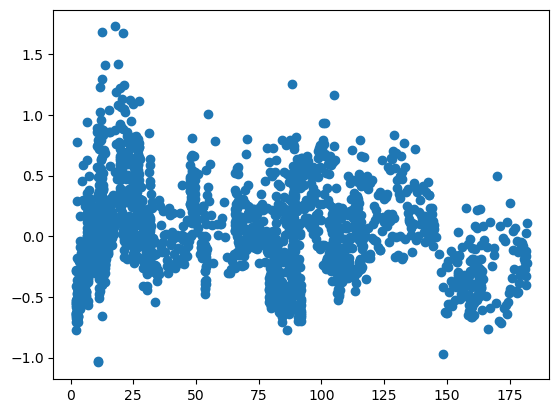

In [38]:
# Visualize predictor continuous variable vs logit values (Age)
plt.scatter(x = bars_cls_linear['Close_50'].values, y = log_odds);
plt.show()

##### Assumption 4: Multicollinearity and Independence

In [39]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [40]:
bars_cls_linear.iloc[:, :6]

,Open_50,High_50,Low_50,Close_50,Volume,Signal
Date,,,,,,
2016-03-15,2.1646,2.240600,2.085600,2.1578,0.221095,0
2016-03-16,2.1592,2.237000,2.082800,2.1550,0.161584,1
2016-03-17,2.1592,2.237200,2.084000,2.1560,0.264590,0
2016-03-18,2.1620,2.241600,2.090000,2.1645,0.266032,1
2016-03-21,2.1714,2.250000,2.099800,2.1750,0.167489,0
...,...,...,...,...,...,...
2024-09-12,151.0895,154.014538,147.209804,150.2580,0.263162,1
2024-09-13,150.8519,153.769938,146.973604,150.0262,0.239965,0
2024-09-16,150.5665,153.377946,146.678244,149.6298,0.254422,1


In [41]:
# Use variance inflation factor to identify any significant multi-collinearity
def calc_vif(df):
    vif = pd.DataFrame()
    vif["variables"] = df.columns
    vif["VIF"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    return(vif)

calc_vif(bars_cls_linear.iloc[:, :6])

,variables,VIF
0,Open_50,542233.957861
1,High_50,598550.746720
2,Low_50,494226.798398
3,Close_50,667210.511532
4,Volume,3.702530
5,Signal,2.079127


##### Add input vars

RSI, MACD, Bollinger Bands

In [67]:
def rsi(df, window):
    delta = df.diff().dropna()
    part1_gain = (delta.where(delta > 0, 0)).shift(1).rolling(window=window-1).mean()
    part2_gain = (delta.where(delta > 0, 0))
    gain = (part1_gain * (window-1) + part2_gain)/window
    
    part1_loss = (-delta.where(delta < 0, 0)).shift(1).rolling(window=window-1).mean()
    part2_loss = (-delta.where(delta < 0, 0))
    loss = (part1_loss * (window-1) + part2_loss)/window
    rs = gain / loss
    # df['RSI'] = 100 - (100 / (1 + rs))
    return 100 - (100 / (1 + rs))


def rsi_cat(df, window):
    df1 = rsi(df, window).dropna()
    return df1.apply(lambda x: 1 if x > 70 else (-1 if x < 30 else 0))

In [100]:
def add_factors(bars):
    bars['rsi'] = rsi(bars['Close'])
    bars['rsi_cat'] = rsi_cat(bars['Close'], 14)
    
    bars['return'] = bars['Close'].pct_change()
    bars['log_return'] = np.log(bars['Close'].pct_change()+1)
    
    bars['volume_change'] = bars['Volume'].pct_change()
    bars['volume_sqrt'] = bars['Volume'].apply(lambda x: np.sqrt(x))
    
    bars['MA5'] = bars['Close'].rolling(window=5).mean()
    bars['MA10'] = bars['Close'].rolling(window=10).mean()
    
    bars['EMA12'] = bars['Close'].ewm(span=12, adjust=False).mean()
    bars['EMA26'] = bars['Close'].ewm(span=26, adjust=False).mean()
    bars['MACD'] = bars['EMA26'] - bars['EMA12']
    bars['Signal_Line'] = bars['MACD'].ewm(span=9, adjust=False).mean()
    
    cols = bars.columns.tolist()
    cols.remove('Signal')
    cols.append('Signal')
    bars = bars[cols]
    
    
    return bars

In [103]:
bars_cls = add_factors(bars_cls).dropna()

1. RSI

In [79]:
delta = 0.015
bars_cls = bars.copy()[['Close', 'Volume']]
bars_cls['Signal'] = [int(row['High'] >= (1 + delta) * row['Open']) for idx, row in bars.iterrows()]

In [80]:
bars_cls

,Close,Volume,Signal
Date,,,
2016-01-04,2.7700,33698464.0,1
2016-01-05,2.7500,13372522.0,0
2016-01-06,2.5050,24280750.0,1
2016-01-07,2.2750,22577907.0,1
2016-01-08,2.1400,34037306.0,1
...,...,...,...
2024-09-12,150.7700,29286166.0,1
2024-09-13,152.3100,25117241.0,0
2024-09-16,152.0800,27677761.0,1


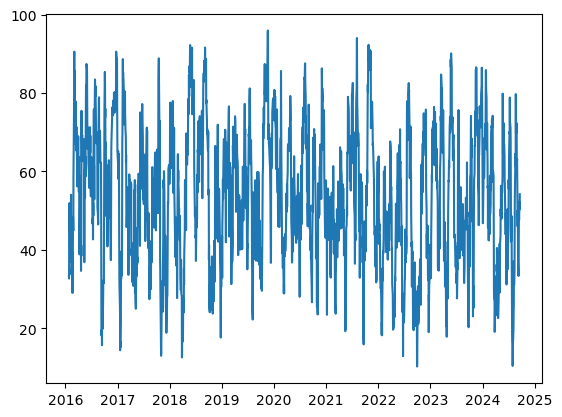

In [76]:
def rsi(df, window=14):
    delta = df.diff().dropna()
    part1_gain = (delta.where(delta > 0, 0)).shift(1).rolling(window=window-1).mean()
    part2_gain = (delta.where(delta > 0, 0))
    gain = (part1_gain * (window-1) + part2_gain)/window
    
    part1_loss = (-delta.where(delta < 0, 0)).shift(1).rolling(window=window-1).mean()
    part2_loss = (-delta.where(delta < 0, 0))
    loss = (part1_loss * (window-1) + part2_loss)/window
    rs = gain / loss
    # df['RSI'] = 100 - (100 / (1 + rs))
    return 100 - (100 / (1 + rs))


def rsi_cat(df, window):
    df1 = rsi(df, window).dropna()
    return df1.apply(lambda x: 1 if x > 70 else (-1 if x < 30 else 0))
    
# rsi_cat(bars_cls['Close_50'], 14)
plt.plot(rsi(bars['Close']).dropna())

2. Returns

In [54]:
bars['Close'].pct_change()

Date
2016-01-04         NaN
2016-01-05   -0.007220
2016-01-06   -0.089091
2016-01-07   -0.091816
2016-01-08   -0.059341
                ...   
2024-09-12    0.006072
2024-09-13    0.010214
2024-09-16   -0.001510
2024-09-17   -0.008285
2024-09-18   -0.001459
Name: Close, Length: 2192, dtype: float64

3. Log Returns (log(1+x))

In [55]:
np.log(bars['Close'].pct_change()+1)

Date
2016-01-04         NaN
2016-01-05   -0.007246
2016-01-06   -0.093312
2016-01-07   -0.096309
2016-01-08   -0.061174
                ...   
2024-09-12    0.006054
2024-09-13    0.010162
2024-09-16   -0.001511
2024-09-17   -0.008320
2024-09-18   -0.001460
Name: Close, Length: 2192, dtype: float64

4. Volume Change

In [56]:
bars['Volume'].pct_change()

Date
2016-01-04         NaN
2016-01-05   -0.603171
2016-01-06    0.815720
2016-01-07   -0.070131
2016-01-08    0.507549
                ...   
2024-09-12   -0.425033
2024-09-13   -0.142351
2024-09-16    0.101943
2024-09-17    0.079892
2024-09-18   -0.609691
Name: Volume, Length: 2192, dtype: float64

5. Sqrt Volume

In [57]:
bars['Volume'].apply(lambda x: np.sqrt(x))

Date
2016-01-04    5805.037812
2016-01-05    3656.845909
2016-01-06    4927.550101
2016-01-07    4751.621513
2016-01-08    5834.149981
                 ...     
2024-09-12    5411.669428
2024-09-13    5011.710387
2024-09-16    5260.965786
2024-09-17    5467.082769
2024-09-18    3415.545491
Name: Volume, Length: 2192, dtype: float64

6. MA5, MA10

In [60]:
bars['Close'].rolling(window=5).mean()
bars['Close'].rolling(window=10).mean()

Date
2016-01-04        NaN
2016-01-05        NaN
2016-01-06        NaN
2016-01-07        NaN
2016-01-08        NaN
               ...   
2024-09-12    142.727
2024-09-13    143.409
2024-09-16    143.761
2024-09-17    145.149
2024-09-18    146.122
Name: Close, Length: 2192, dtype: float64

7. MACD

In [ ]:
exp1 = bars['Close'].ewm(span=12, adjust=False).mean()
exp2 = bars['Close'].ewm(span=26, adjust=False).mean()
exp1 - exp2

##### Training & Testing

In [104]:
X = bars_cls.drop(columns = ['Signal'])
y = bars_cls["Signal"]

# train_test_split 
dev_test_split = int(0.8*X.shape[0])
X_dev_df, X_test_df, y_dev_df, y_test_df= X.iloc[:dev_test_split], X.iloc[dev_test_split:], y.iloc[:dev_test_split], y.iloc[dev_test_split:]


train_val_split = int(0.75*X_dev_df.shape[0])
X_train_df, X_val_df, y_train_df, y_val_df = X_dev_df.iloc[:train_val_split], X_dev_df.iloc[train_val_split:], y_dev_df.iloc[:train_val_split], y_dev_df.iloc[train_val_split:]                      

In [33]:
# period = 3

# full_data = pd.DataFrame()

# full_data.index = bars_cls.index

# for i in range(1, period + 1):
#     for feature in ['Open','High','Low','Close','Volume']: # ['Close','Volume']:
#         full_data[f'{feature}_-{i}'] = bars_cls[feature].shift(i)


        
# full_data['Signal_next'] = bars_cls['Signal'].shift(-1)

# full_data.dropna(inplace=True)
# full_data.head()

In [ ]:
# X = full_data.drop(columns = ['Signal_next'])
# y = full_data["Signal_next"]

# # train_test_split 
# dev_test_split = int(0.8*X.shape[0])
# X_dev_df, X_test_df, y_dev_df, y_test_df= X.iloc[:dev_test_split], X.iloc[dev_test_split:], y.iloc[:dev_test_split], y.iloc[dev_test_split:]


# train_val_split = int(0.75*X_dev_df.shape[0])
# X_train_df, X_val_df, y_train_df, y_val_df = X_dev_df.iloc[:train_val_split], X_dev_df.iloc[train_val_split:], y_dev_df.iloc[:train_val_split], y_dev_df.iloc[train_val_split:]                      

In [105]:
ss = MinMaxScaler()
X_train_scaled = ss.fit_transform(X_train_df)
X_val_scaled = ss.transform(X_val_df)
X_test_scaled = ss.transform(X_test_df)

In [106]:
clf = LogisticRegression(random_state=42).fit(X_train_scaled, y_train_df)

In [151]:
# pred_prob

In [152]:
import pickle

In [153]:
# save the model to disk
filename = 'finalized_model.sav'
pickle.dump(clf, open(filename, 'wb'))

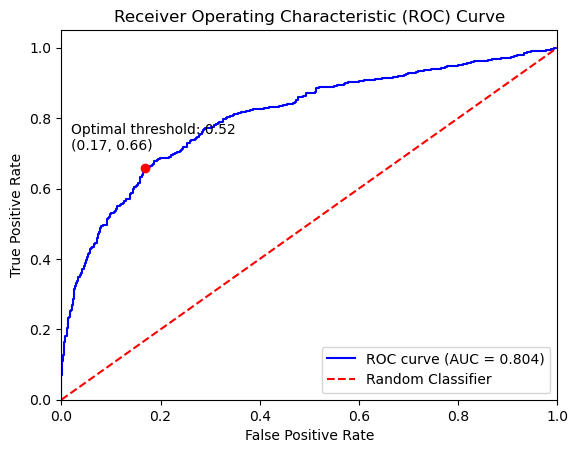

In [107]:
from sklearn.metrics import roc_curve, auc


pred_prob = clf.predict_proba(X_train_scaled)
# Assuming pred_prob contains the predicted probabilities for the positive class
y_score = pred_prob[:, 1]

# Calculate false positive rate, true positive rate, and thresholds
fpr, tpr, thresholds = roc_curve(y_train_df, y_score)

# Calculate the AUC
roc_auc = auc(fpr, tpr)

optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
optimal_point = (fpr[optimal_idx], tpr[optimal_idx])

# Plot the ROC curve
fig, ax = plt.subplots()
ax.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.3f})')
ax.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random Classifier')
ax.plot(optimal_point[0], optimal_point[1], 'ro', markersize=6)
ax.text(optimal_point[0]-0.15, optimal_point[1]+0.05, f'Optimal threshold: {optimal_threshold:.2f}\n({optimal_point[0]:.2f}, {optimal_point[1]:.2f})')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Receiver Operating Characteristic (ROC) Curve')
ax.legend(loc="lower right")
plt.show()

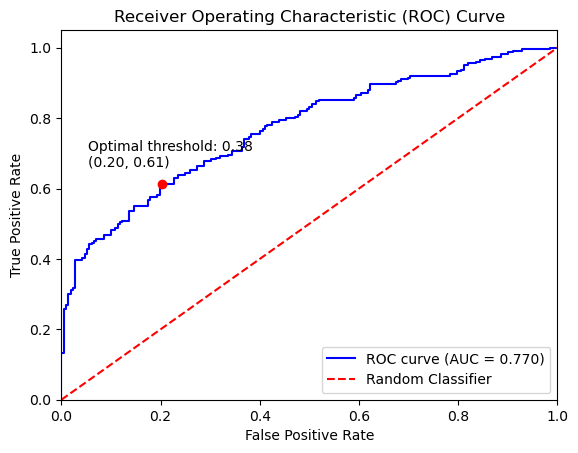

In [108]:
from sklearn.metrics import roc_curve, auc

pred_prob = clf.predict_proba(X_test_scaled)

# Assuming pred_prob contains the predicted probabilities for the positive class
y_score = pred_prob[:, 1]

# Calculate false positive rate, true positive rate, and thresholds
fpr, tpr, thresholds = roc_curve(y_test_df, y_score)

# Calculate the AUC
roc_auc = auc(fpr, tpr)

optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
optimal_point = (fpr[optimal_idx], tpr[optimal_idx])

# Plot the ROC curve
fig, ax = plt.subplots()
ax.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.3f})')
ax.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random Classifier')
ax.plot(optimal_point[0], optimal_point[1], 'ro', markersize=6)
ax.text(optimal_point[0]-0.15, optimal_point[1]+0.05, f'Optimal threshold: {optimal_threshold:.2f}\n({optimal_point[0]:.2f}, {optimal_point[1]:.2f})')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Receiver Operating Characteristic (ROC) Curve')
ax.legend(loc="lower right")
plt.show()

In [141]:
signals = []
for i in range(len(pred_prob)):
    if pred_prob[i][1] > 0.38:
        signals.append(1)
    else:
        signals.append(0)
signals.head()

AttributeError: 'list' object has no attribute 'head'

In [142]:
X_test_df

,Close,Volume,rsi,rsi_cat,return,log_return,volume_change,volume_sqrt,MA5,MA10,EMA12,EMA26,MACD,Signal_Line
Date,,,,,,,,,,,,,,
2022-12-22,63.8600,78107407.0,26.910299,-1.0,-0.056442,-0.058098,0.664487,8837.839498,65.31800,67.29600,67.587897,68.802509,1.214612,0.226085
2022-12-23,64.5200,47843400.0,30.538922,0.0,0.010335,0.010282,-0.387467,6916.892366,65.14000,66.88900,67.115912,68.485286,1.369374,0.454742
2022-12-27,63.2700,38184975.0,33.552632,0.0,-0.019374,-0.019564,-0.201876,6179.399243,64.87600,66.14900,66.524234,68.098969,1.574735,0.678741
2022-12-28,62.5700,40997030.0,32.677346,0.0,-0.011064,-0.011125,0.073643,6402.892315,64.38000,65.24100,65.915890,67.689415,1.773525,0.897698
2022-12-29,64.8200,44259982.0,38.115271,0.0,0.035960,0.035328,0.079590,6652.817599,63.80800,64.83000,65.747292,67.476866,1.729574,1.064073
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-09-12,150.7700,29286166.0,49.159892,0.0,0.006072,0.006054,-0.425033,5411.669428,143.19400,142.72700,144.721308,145.646335,0.925027,1.517994
2024-09-13,152.3100,25117241.0,47.509793,0.0,0.010214,0.010162,-0.142351,5011.710387,146.78600,143.40900,145.888799,146.139940,0.251141,1.264624
2024-09-16,152.0800,27677761.0,52.139202,0.0,-0.001510,-0.001511,0.101943,5260.965786,149.57200,143.76100,146.841291,146.579944,-0.261347,0.959429


In [147]:
signals = pd.DataFrame({'signals': signals}, index=X_test_df.index)

In [164]:
# signals.shift(1) 
signals.shift(1)['signals'] * bars_cls['Close'].pct_change()[signals.index]

Date
2022-12-22         NaN
2022-12-23    0.000000
2022-12-27   -0.019374
2022-12-28   -0.000000
2022-12-29    0.000000
                ...   
2024-09-12    0.006072
2024-09-13    0.000000
2024-09-16   -0.000000
2024-09-17   -0.000000
2024-09-18   -0.000000
Length: 436, dtype: float64

In [165]:
Cumulative_Returns = (1 + signals.shift(1)['signals'] * bars_cls['Close'].pct_change()[signals.index]).cumprod()
Cumulative_Returns

Date
2022-12-22         NaN
2022-12-23    1.000000
2022-12-27    0.980626
2022-12-28    0.980626
2022-12-29    0.980626
                ...   
2024-09-12    1.709899
2024-09-13    1.709899
2024-09-16    1.709899
2024-09-17    1.709899
2024-09-18    1.709899
Length: 436, dtype: float64

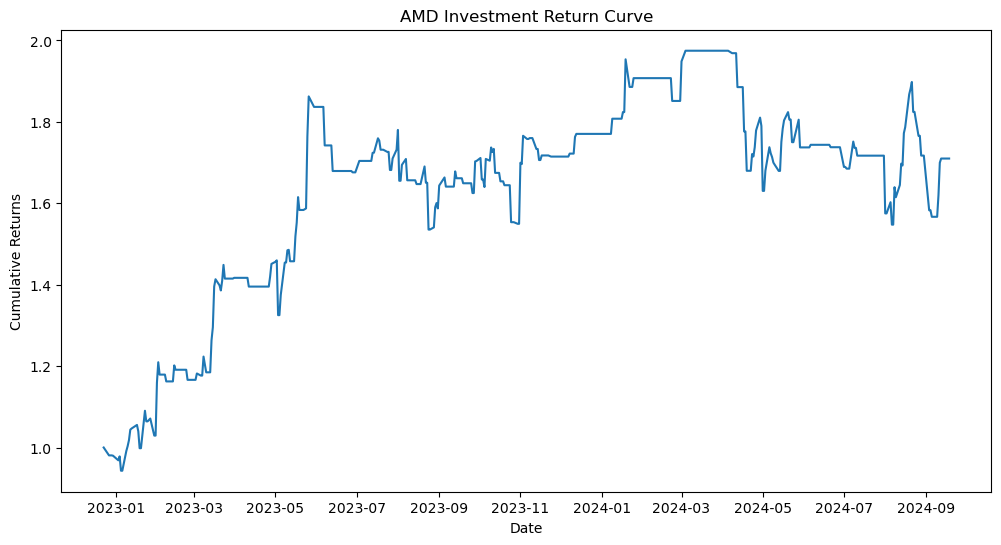

In [169]:
plt.figure(figsize=(12,6))
plt.plot(X_test_df.index, Cumulative_Returns)
plt.title('AMD Investment Return Curve')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.show()

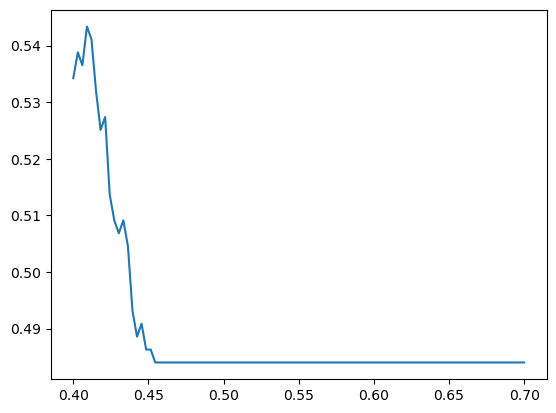

In [113]:
res = []
for i in np.linspace(0.4, 0.7, num=100):
    pred = pd.DataFrame(pred_prob).apply(lambda x: 1 if x[1] > i else 0, axis=1)
#     conf_matrix = confusion_matrix(pred, y_train_df)

#     TP = conf_matrix[1, 1]
#     TN = conf_matrix[0, 0]
#     FP = conf_matrix[0, 1]
#     FN = conf_matrix[1, 0]
    
#     print((TP + TN) / sum(map(sum, conf_matrix)))
#     print(accuracy_score(y_train_df, pred))
    res.append(accuracy_score(y_test_df, pred))

fig = plt.figure()
ax = plt.axes()
ax.plot(np.linspace(0.4, 0.7, num=100), res)

In [100]:
threshold = np.linspace(0.4, 0.7, num=100)[res.index(max(res))]

In [90]:
pred = pd.DataFrame(pred_prob).apply(lambda x: 1 if x[1] > 0.51 else 0, axis=1)
pred

0       1
1       1
2       1
3       1
4       1
       ..
1306    0
1307    0
1308    0
1309    0
1310    0
Length: 1311, dtype: int64

In [91]:
from sklearn.metrics import confusion_matrix, accuracy_score

In [92]:
conf_matrix = confusion_matrix(pred, y_train_df)

TP = conf_matrix[1, 1]
TN = conf_matrix[0, 0]
FP = conf_matrix[0, 1]
FN = conf_matrix[1, 0]

In [96]:
# Classification Accuracy: Overall, how often is the classifier correct?
# use float to perform true division, not integer division
print((TP / (TP + FP))) # precision
print((TP / (TP + FN))) # recall
print(accuracy_score(y_train_df, pred))

0.7181409295352323
0.5461801596351197
0.5530129672006102


In [94]:
### Code here
lgr = LogisticRegression(alpha=0, t=100, eta=1e-3)
loss_train = lgr.train(X_train_scaled, np.array(y_train_df.tolist()))

loss_train = np.squeeze(loss_train)

fig, ax = plt.subplots()
ax.plot(range(100), loss_train)
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.set_title('Training Loss over Epochs')

TypeError: LogisticRegression.__init__() got an unexpected keyword argument 'alpha'

#### Linear Regression

In [38]:
### Code here
lr = LinearRegression()
lr.train(X_train_scaled, y_train_df)

# predictions
y_pred_train = lr.predict(X_train_scaled)
y_pred_val = lr.predict(X_val_scaled)
y_pred_test = lr.predict(X_test_scaled)

# Export R^2
r2_train = r2_score(y_pred_train, y_train_df)
r2_val = r2_score(y_pred_val, y_val_df)
r2_test = r2_score(y_pred_test, y_test_df)
print(f"R^2 score on training set: {r2_train}")
print(f"R^2 score on training set: {r2_val}")
print(f"R^2 score on training set: {r2_test}")

# Get report
get_report(y_pred_train, y_train_df)
get_report(y_pred_val, y_val_df)
get_report(y_pred_test, y_test_df)

NameError: name 'LinearRegression' is not defined

# Portfolio

In [102]:
class MarketOnClosePortfolio(Portfolio):
    def __init__(self, symbol, bars, signals, initial_capital=100000.0):
        self.symbol = symbol
        self.bars = bars
        self.signals = signals
        self.initial_capital = float(initial_capital)
        self.positions = self.generate_positions()

    def generate_positions(self):
        positions = pd.DataFrame(index=self.bars.index).fillna(0.0)
        positions[self.symbol] = 100 * self.signals["signal"]
        return positions.cumsum()

    def backtest_portfolio(self):
        # portfolio = pd.DataFrame({'pos_value': self.positions[self.symbol] * self.bars['Close']})

        # pos_diff = self.positions.diff()

        # portfolio['holdings'] = self.positions[self.symbol] * self.bars['Close']
        # portfolio['cash'] = self.initial_capital - (pos_diff[self.symbol] * self.bars['Close']).cumsum()

        # portfolio['total'] = portfolio['cash'] + portfolio['holdings']
        # portfolio['returns'] = portfolio['total'].pct_change()

        portfolio = pd.DataFrame(index=self.bars.index)
        portfolio["holdings"] = self.positions[self.symbol] * self.bars["Close"]
        pos_diff = self.positions.diff()
        portfolio["cash"] = (
            self.initial_capital - (pos_diff[self.symbol] * self.bars["Close"]).cumsum()
        )
        portfolio["total"] = portfolio["cash"] + portfolio["holdings"]
        portfolio["returns"] = portfolio["total"].pct_change()

        return portfolio

In [103]:
class MarketOnOpenPortfolio(Portfolio):
    """Inherits Portfolio to create a system that purchases 100 units of
    a particular symbol upon a long/short signal, assuming the market
    open price of a bar.

    In addition, there are zero transaction costs and cash can be immediately
    borrowed for shorting (no margin posting or interest requirements).

    Requires:
    symbol - A stock symbol which forms the basis of the portfolio.
    bars - A DataFrame of bars for a symbol set.
    signals - A pandas DataFrame of signals (1, 0, -1) for each symbol.
    initial_capital - The amount in cash at the start of the portfolio."""

    def __init__(self, symbol, bars, signals, risk_ratio=0.05, stop_loss_percent=0.1, initial_capital=100000.0):
        self.symbol = symbol
        self.bars = bars
        self.signals = signals
        self.initial_capital = float(initial_capital)
        # self.cash = self.initial_capital
        self.risk_ratio = risk_ratio
        self.stop_loss_percent = stop_loss_percent
        self.positions = self.generate_positions()
    
    def generate_positions(self):
        positions = pd.DataFrame(index=self.signals.index, columns=[self.symbol])
        positions[self.symbol] = positions[self.symbol].mask(pd.isna(positions[self.symbol]), 0)
        equity = [self.initial_capital] # length n
        
        for i in range(1, len(self.signals)):
            signal = self.signals['signal'].iloc[i]
            open_price = self.bars["Open"].iloc[i]
            prev_open_price = self.bars["Open"].iloc[i-1]

#             historical = [abs(j - self.initial_capital) for j in equity[:i]]
#             if max(historical) != 0:
#                 trade_risk = max(historical)
#             else:
#                 trade_risk = open_price

#             num_of_contract = int(equity[i-1] * self.risk_ratio / trade_risk)
            num_of_contract = int(equity[i-1] * self.risk_ratio / (open_price * self.stop_loss_percent))
            
            

            if signal == 1:
                positions.iloc[i] = num_of_contract
            elif signal == -1:
                positions.iloc[i] = 0
            else:
                positions.iloc[i] = positions.iloc[i-1]

            pnl = float(positions.iloc[i-1].values) * (open_price - prev_open_price)
            equity.append(equity[i-1] + pnl)

        return positions
    
    
    def backtest_portfolio(self):
        """Constructs a portfolio from the positions DataFrame by
        assuming the ability to trade at the precise market open price
        of each bar (an unrealistic assumption!).

        Calculates the total of cash and the holdings (market price of
        each position per bar), in order to generate an equity curve
        ('total') and a set of bar-based returns ('returns').

        Returns the portfolio object to be used elsewhere."""
    
        portfolio = pd.DataFrame(index=self.bars.index)
        portfolio["holdings"] = self.positions[self.symbol] * self.bars["Open"]
        pos_diff = self.positions.diff()
        portfolio["cash"] = (
            self.initial_capital - (pos_diff[self.symbol] * self.bars["Open"]).cumsum()
        )
        portfolio["equity"] = portfolio["cash"] + portfolio["holdings"]
        portfolio["returns"] = portfolio["equity"].pct_change()
        print(self.risk_ratio)

        return portfolio

In [104]:
# initial_capital = 100000
# symbol = 'AMD'
# positions = pd.DataFrame(index=signals.index, columns=[symbol])
# positions[symbol] = positions[symbol].mask(pd.isna(positions[symbol]), 0)
# equity = [initial_capital] # length n
# risk_ratio = 0.05

# for i in range(1, len(signals)):
#     signal = signals['signal'].iloc[i]
#     open_price = bars["Open"].iloc[i]
#     prev_open_price = bars["Open"].iloc[i-1]

#     historical = [abs(i - initial_capital) for i in equity[:i]]
#     if max(historical) != 0:
#         trade_risk = max(historical)
#     else:
#         trade_risk = open_price
    
#     num_of_contract = int(equity[i-1] * risk_ratio / trade_risk)

#     if signal != 0:
#         positions.iloc[i] = num_of_contract

#     else:
#         positions.iloc[i] = positions.iloc[i-1]

#     pnl = positions.iloc[i-1] * (open_price - prev_open_price)
#     equity.append(equity[i-1] + pnl)

# return positions

In [105]:
# initial_capital = 100000
# symbol = 'AMD'
# positions = pd.DataFrame(index=signals.index, columns=[symbol])
# positions[symbol] = positions[symbol].mask(pd.isna(positions[symbol]), 0)
# equity = [initial_capital] # length n
# risk_ratio = 0.05

# Performance

In [106]:
def create_sharpe_ratio(returns, risk_free_rate=0, periods=252):
    """
    Create the Sharpe ratio for the strategy, based on a 
    benchmark of zero (i.e. no risk-free rate information).

    Parameters:
    returns - A pandas Series representing period percentage returns.
    periods - Daily (252), Hourly (252*6.5), Minutely(252*6.5*60) etc.
    """
    return np.sqrt(periods) * (np.mean(returns) - risk_free_rate) / np.std(returns)


def create_drawdowns(equity_curve):
    """
    Calculate the largest peak-to-trough drawdown of the PnL curve
    as well as the duration of the drawdown. Requires that the 
    pnl_returns is a pandas Series.

    Parameters:
    pnl - A pandas Series representing period percentage returns.

    Returns:
    drawdown, duration - Highest peak-to-trough drawdown and duration.
    """
    
    # Calculate the cumulative returns curve 
    # and set up the High Water Mark
    # Then create the drawdown and duration series
    hwm = [0]
    eq_idx = equity_curve.index
    drawdown = pd.Series(index = eq_idx, dtype=float)
    duration = pd.Series(index = eq_idx, dtype=float)

    # Loop over the index range
    for t in range(1, len(eq_idx)):
        cur_hwm = max(hwm[t-1], equity_curve[t])
        hwm.append(cur_hwm)
        drawdown[t]= hwm[t] - equity_curve[t]
        duration[t]= 0 if drawdown[t] == 0 else duration[t-1] + 1
    return drawdown.max(), duration.max()

# Execution

## Random Strategy Execution

In [107]:
if __name__ == "__main__":
    # Obtain daily bars of SPY (ETF that generally
    # follows the S&P500) from Quandl (requires 'pip install Quandl'
    # on the command line)

    # Fetch SPY data
    symbol = "SPY"
    bars = yf.download(symbol, period="2y")  # start='2024-05-01'
    bars.index = bars.index.date

    # Create a set of random forecasting signals for SPY
    rfs = RandomForecastingStrategy(symbol, bars)
    signals = rfs.generate_signals()

    # Create a portfolio of SPY
    portfolio = MarketOnOpenPortfolio(symbol, bars, signals, initial_capital=100000.0)
    returns = portfolio.backtest_portfolio()

[*********************100%***********************]  1 of 1 completed

0.05



/tmp/ipykernel_16118/1428518710.py:19: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  signals["signal"][0:5] = 0.0
/tmp/ipykernel_16118/966422173.py:77: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated 

## Sentiment Analysis Execution

[*********************100%%**********************]  1 of 1 completed


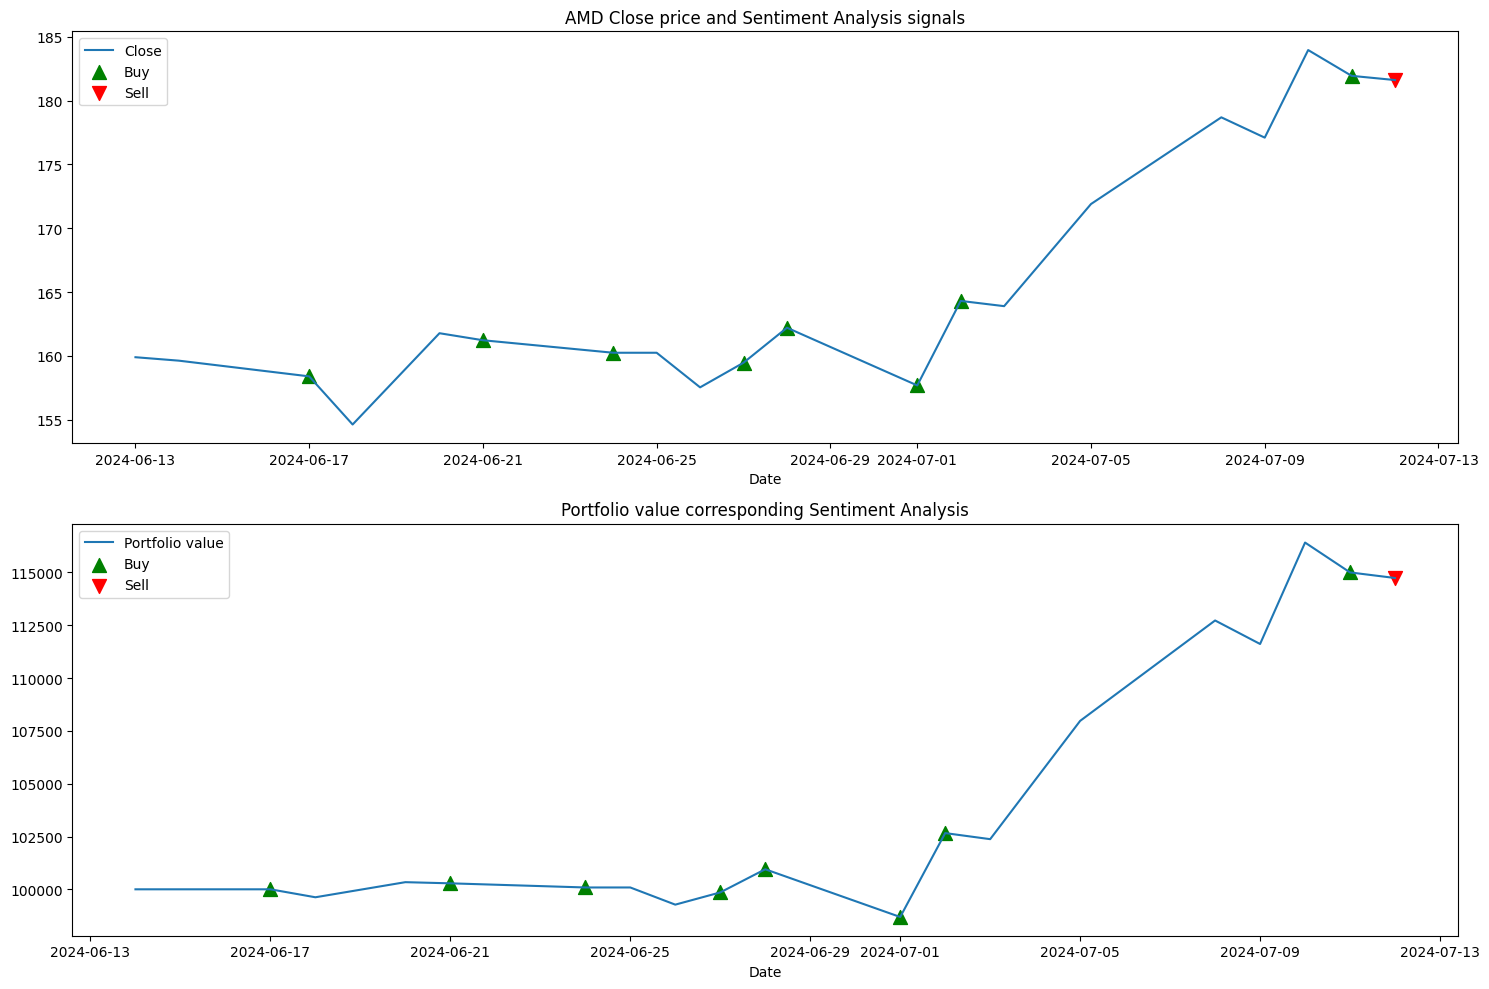

In [51]:
if __name__ == "__main__":
    symbol = "AMD"
    bars = yf.download(tickers=symbol, period="1mo")
    threshold = 0.2
    news_api_key = userdata.get("news_api_key")

    senti_analysis = SentimentAnalysisStrategy(symbol, bars, threshold, news_api_key)
    signals = senti_analysis.generate_signals()

    portfolio = MarketOnClosePortfolio(symbol, bars, signals, initial_capital=100000.0)
    returns = portfolio.backtest_portfolio()

    fig, ax = plt.subplots(2, 1, figsize=(15, 10), tight_layout=True)
    # fig.patch.set_facecolor('white')
    ax[0].plot(bars["Close"], label="Close")
    ax[0].scatter(
        bars["Close"][signals["signal"] == 1.0].index,
        bars["Close"][signals["signal"] == 1.0].values,
        100,
        c="green",
        marker="^",
        label="Buy",
    )
    ax[0].scatter(
        bars["Close"][signals["signal"] == -1.0].index,
        bars["Close"][signals["signal"] == -1.0].values,
        100,
        c="red",
        marker="v",
        label="Sell",
    )

    ax[0].legend()
    ax[0].set_title(f"{symbol} Close price and Sentiment Analysis signals")
    ax[0].set_xlabel("Date")

    ax[1].plot(returns["total"], label="Portfolio value")
    ax[1].scatter(
        returns[signals["signal"] == 1.0].index,
        returns["total"][signals["signal"] == 1.0],
        s=100,
        c="green",
        marker="^",
        label="Buy",
    )
    ax[1].scatter(
        returns[signals["signal"] == -1.0].index,
        returns["total"][signals["signal"] == -1.0],
        s=100,
        c="red",
        marker="v",
        label="Sell",
    )

    ax[1].legend()
    ax[1].set_title(f"Portfolio value corresponding Sentiment Analysis")
    ax[1].set_xlabel("Date")

## Moving Average Crossovers Strategy Execution

In [59]:
!pip install backtrader

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 419.5/419.5 kB 16.4 MB/s eta 0:00:00


In [32]:
from datetime import datetime
import backtrader as bt

In [71]:
bars

,timestamp,Open,High,Low,Close,Volume
Date,,,,,,
2016-01-04,2016-01-04 05:00:00+00:00,32.290,32.580,32.040,32.370,9777779.0
2016-01-05,2016-01-05 05:00:00+00:00,32.980,33.440,32.500,32.890,13406139.0
2016-01-06,2016-01-06 05:00:00+00:00,32.350,32.500,31.160,31.530,11606505.0
2016-01-07,2016-01-07 05:00:00+00:00,30.740,30.953,29.880,30.280,16989171.0
2016-01-08,2016-01-08 05:00:00+00:00,30.670,30.700,29.565,29.630,10461559.0
...,...,...,...,...,...,...
2024-08-21,2024-08-21 04:00:00+00:00,127.315,129.350,126.660,128.500,257883572.0
2024-08-22,2024-08-22 04:00:00+00:00,130.020,130.750,123.100,123.740,376189076.0
2024-08-23,2024-08-23 04:00:00+00:00,125.860,129.600,125.220,129.370,323230332.0


In [82]:
bars.values

array([[3.22900000e+01, 3.25800000e+01, 3.20400000e+01, 3.23700000e+01,
        9.77777900e+06],
       [3.29800000e+01, 3.34400000e+01, 3.25000000e+01, 3.28900000e+01,
        1.34061390e+07],
       [3.23500000e+01, 3.25000000e+01, 3.11600000e+01, 3.15300000e+01,
        1.16065050e+07],
       ...,
       [1.25860000e+02, 1.29600000e+02, 1.25220000e+02, 1.29370000e+02,
        3.23230332e+08],
       [1.29570000e+02, 1.31260000e+02, 1.24370000e+02, 1.26460000e+02,
        3.31964672e+08],
       [1.25050000e+02, 1.28980000e+02, 1.23880000e+02, 1.28120000e+02,
        1.43951705e+08]])

In [84]:
bars0 = pd.DataFrame(index=[pd.Timestamp(i) for i in bars.index])
bars0[bars.columns.tolist()] = bars.values
bars0

Timestamp('2016-01-04 00:00:00')

In [87]:
%matplotlib inline

class SmaCross(bt.SignalStrategy):
    def __init__(self):
        sma1, sma2 = bt.ind.SMA(period=10), bt.ind.SMA(period=30)
        crossover = bt.ind.CrossOver(sma1, sma2)
        self.signal_add(bt.SIGNAL_LONG, crossover)

cerebro = bt.Cerebro()
cerebro.addstrategy(SmaCross)

bars0 = pd.DataFrame(index=[pd.Timestamp(i) for i in bars.index])
bars0[bars.columns.tolist()] = bars.values
data0 = bt.feeds.PandasData(dataname=bars0)
bars
cerebro.adddata(data0)

cerebro.run()
cerebro.plot()

<IPython.core.display.Javascript object>

[[<Figure size 640x480 with 5 Axes>]]

In [50]:
bars.index[0].to_pydatetime()

AttributeError: 'str' object has no attribute 'to_pydatetime'

In [24]:
from alpaca.data.timeframe import TimeFrame
from alpaca.data.requests import StockBarsRequest
from alpaca.data.historical import StockHistoricalDataClient # Create stock historical data client

In [468]:
bars["Close"]

,Close
Date,
2016-01-04,32.37
2016-01-05,32.89
2016-01-06,31.53
2016-01-07,30.28
2016-01-08,29.63
...,...
2024-08-21,128.50
2024-08-22,123.74
2024-08-23,129.37


In [471]:
signals

,signal,short_mavg,long_mavg
Date,,,
2016-01-04,0.0,32.370000,32.370000
2016-01-05,0.0,32.630000,32.630000
2016-01-06,0.0,32.263333,32.263333
2016-01-07,0.0,31.767500,31.767500
2016-01-08,0.0,31.340000,31.340000
...,...,...,...
2024-08-21,0.0,120.759200,521.406800
2024-08-22,0.0,120.815800,513.607900
2024-08-23,0.0,120.899200,505.956400


In [56]:
def backtesting_plot(signals, returns):
    """
    signals: dataframe with column 0/1
    returns: dataframe with [[holdings, cash, equity, returns]]
    """
    
    # backtesting results
    fig, ax = plt.subplots(2, 1, figsize=(15, 10), tight_layout=True)
    # fig.patch.set_facecolor('white')
    ax[0].plot(bars["Close"], label="Close")
    ax[0].scatter(
        bars["Close"][signals["signal"] == 1.0].index,
        bars["Close"][signals["signal"] == 1.0],
        100,
        c="green",
        marker="^",
    ) # buy signals
    ax[0].scatter(
        bars["Close"][signals["signal"] == -1.0].index,
        bars["Close"][signals["signal"] == -1.0],
        100,
        c="red",
        marker="v",
    ) # sell signals
    
    
    if "short_mavg" in signals.columns:
        # Long/short moving average
        ax[0].plot(signals[["short_mavg", "long_mavg"]], label=["short_sma", "long_sma"])
        ax[0].set_title(
            f"{symbol} Close price and {short_window}d-SMA and {long_window}d-SMA for {int(len(signals)/252)} years"
        )
    else:
        ax[0].set_title(
            f"{symbol} Close price for {int(len(signals)/252)} years"
        )
    
    ax[0].set_xlabel("Date")
    ax[0].legend()
    
    # Equity curve
    ax[1].plot(returns["equity"])
    ax[1].scatter(
        returns[signals["signal"] == 1.0].index,
        returns["equity"][signals["signal"] == 1.0],
        s=100,
        c="green",
        marker="^",
    )
    ax[1].scatter(
        returns[signals["signal"] == -1.0].index,
        returns["equity"][signals["signal"] == -1.0],
        s=100,
        c="red",
        marker="v",
    )

/tmp/ipykernel_26799/2782439365.py:22: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  signals["signal"][self.short_window :] = np.where(
/tmp/ipykernel_26799/966422173.py:77: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, 

0.05


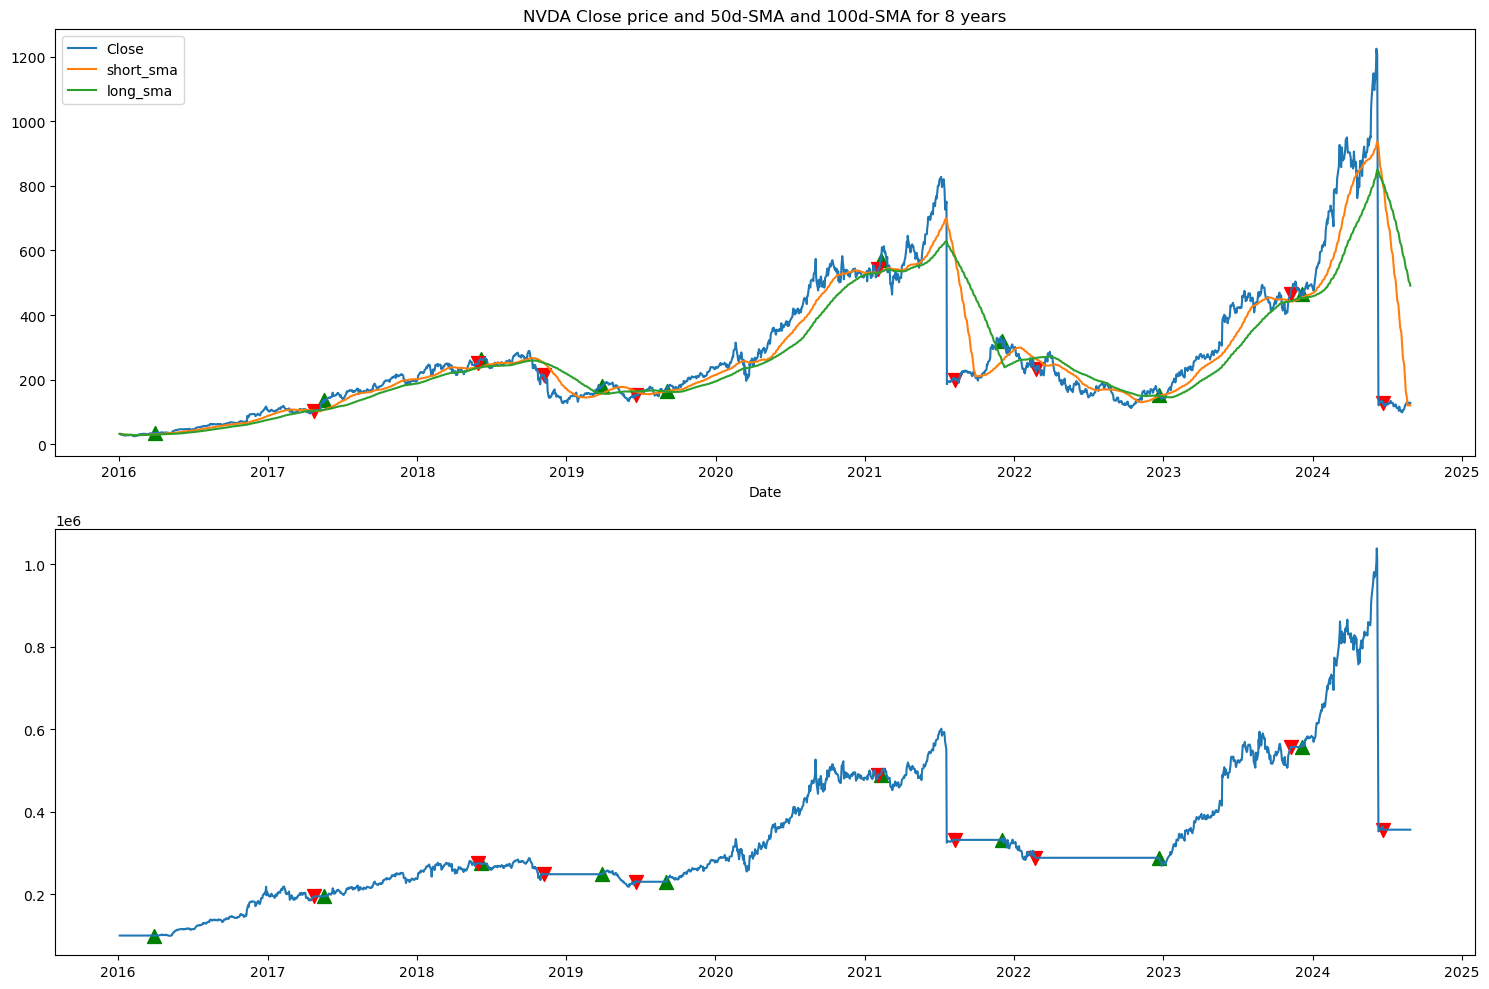

In [72]:
if __name__ == "__main__":
    # symbol = "AMD"
    # symbol = 'NKE'
    symbol = 'NVDA'
    
    # Load data
    # bars = yf.download(tickers=symbol, period="10y")
    api_key = "PK6IRONYS5AQ646ZTDKX"
    api_secret = "HEYwi2T3MzAmYgednADOq0g6pEjuULcEz0Hbdqg8"
    start_date = "2014-01-01 00:00:00"
    client = StockHistoricalDataClient(api_key, api_secret)
    bars = DataLoader(client).fetch_historical_data(symbol, start_date)
    
    
    short_window, long_window = 50, 100

    mac = MovingAverageCrossStrategy(
        symbol, bars, short_window=short_window, long_window=long_window
    )
    signals = mac.generate_signals()

    portfolio = MarketOnOpenPortfolio(symbol, bars, signals, risk_ratio=0.05, stop_loss_percent=0.1, initial_capital=100000.0)
    returns = portfolio.backtest_portfolio()
    

    backtesting_plot(signals, returns)

In [ ]:
2016-01-04 05:00:00+00:00

In [458]:
signals["signal"][signals["signal"] == 1.0]

Date
2016-03-30    1.0
2017-05-19    1.0
2018-06-07    1.0
2019-03-29    1.0
2019-09-03    1.0
2021-02-09    1.0
2021-12-02    1.0
2022-12-22    1.0
2023-12-05    1.0
Name: signal, dtype: float64

In [ ]:
signals[signals["signal"] == 1.0]

In [451]:
np.mean(returns['returns'])

-9.678937775024335e-06

In [446]:
create_sharpe_ratio(returns['returns'])

-0.02359813746824778

In [447]:
create_drawdowns(returns['returns'])

/tmp/ipykernel_9001/208468363.py:36: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cur_hwm = max(hwm[t-1], equity_curve[t])
/tmp/ipykernel_9001/208468363.py:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  drawdown[t]= hwm[t] - equity_curve[t]
/tmp/ipykernel_9001/208468363.py:38: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  drawdown[t]= hwm[t] - equity_curve[t]
/tmp/ipykernel_9001/208468363.py:39: FutureWarning: Series.__geti

(0.14021876825638346, 986.0)

In [448]:
len(returns['returns'].dropna().tolist()) / 252

8.626984126984127

In [449]:
# Step 1: Calculate the total return over the entire period
daily_returns = np.mean(returns['returns'].dropna().tolist())
# total_return = np.prod(1 + daily_returns) - 1
total_return = returns['equity'][-1] / returns['equity'][1]

# Step 2: Calculate the number of years
n_years = len(returns['returns'].dropna().tolist()) / 252  # Assuming 252 trading days in a year

# Step 3: Calculate the annualized return
annualized_return = (1 + total_return) ** (1 / n_years) - 1

print(f"Annualized Return: {annualized_return*100:.2f}%")

Annualized Return: 7.95%


/tmp/ipykernel_9001/3677910553.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  total_return = returns['equity'][-1] / returns['equity'][1]


## Logistic Regression execution

/tmp/ipykernel_16118/966422173.py:77: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  portfolio["returns"] = portfolio["equity"].pct_change()
/tmp/ipykernel_16118/2280836868.py:90: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  returns[signals["signal"] == 1.0].index,
/tmp/ipykernel_16118/2280836868.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  returns[signals["signal"] == -1.0].index,


0.05


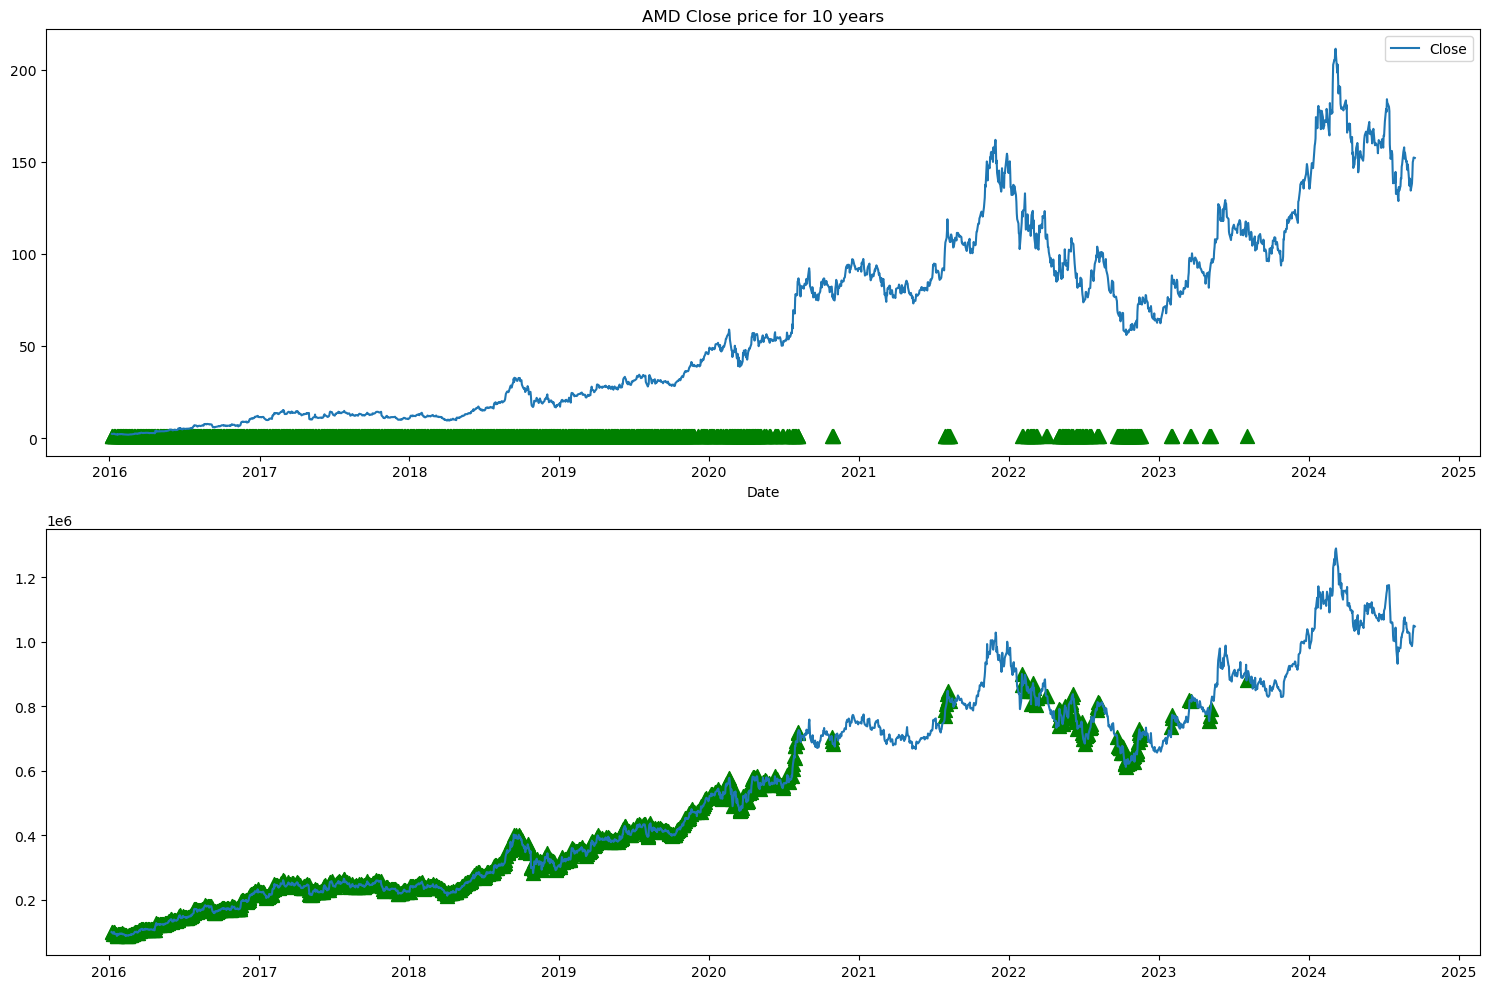

In [108]:
if __name__ == "__main__":
    symbol = "AMD"
    
    # Load data
    # bars = yf.download(tickers=symbol, period="10y")
#     api_key = "PK6IRONYS5AQ646ZTDKX"
#     api_secret = "HEYwi2T3MzAmYgednADOq0g6pEjuULcEz0Hbdqg8"
#     client = StockHistoricalDataClient(api_key, api_secret)
#     request_params = StockBarsRequest(
#                             symbol_or_symbols=[symbol],
#                             timeframe=TimeFrame.Day,
#                             start="2014-01-01 00:00:00"
#                      )
#     bars = client.get_stock_bars(request_params)
#     bars_df = bars.df

#     bars_df = (
#         bars_df[['open', 'high', 'low', 'close', 'volume']]
#         .reset_index().drop('symbol', axis=1)
#     )

#     bars = (
#         bars_df
#         .set_index(pd.to_datetime(bars_df['timestamp']))
#         .rename(columns={'open': 'Open', 'high': 'High', 'low': 'Low', 'close': 'Close', 'volume': 'Volume'})
#     )

#     bars.index = bars.index.strftime('%Y-%m-%d')
#     bars.index.name = 'Date'

    api_key = "PK6IRONYS5AQ646ZTDKX"
    api_secret = "HEYwi2T3MzAmYgednADOq0g6pEjuULcEz0Hbdqg8"
    client = StockHistoricalDataClient(api_key, api_secret)

    start_date = "2014-01-01 00:00:00"

    data_loader = DataLoader(client)
    bars = data_loader.fetch_historical_data(symbol, start_date=start_date)
    
    
    period = 3
    full_data = bars.copy()
    feature_lst = ['Open', 'High', 'Low', 'Close', 'Volume']
    full_data[feature_lst] = full_data[feature_lst].rolling(period).mean()
    full_data.dropna(inplace=True)
#     full_data = pd.DataFrame()
#     full_data.index = bars.index

#     for i in range(1, period + 1):
#         for feature in ['Open','High','Low','Close','Volume']: # ['Close','Volume']:
#             full_data[f'{feature}_-{i}'] = bars[feature].shift(i)

#     full_data.dropna(inplace=True)
    
    clf_pred = pickle.load(open(filename, 'rb'))
    lgr = LogisticRegressionStrategy(threshold, symbol, full_data, clf_pred)
    signals = lgr.generate_signals()
    

    portfolio = MarketOnOpenPortfolio(symbol, bars, signals, initial_capital=100000.0)
    returns = portfolio.backtest_portfolio()[period:]
    
    
    # backtesting results
    fig, ax = plt.subplots(2, 1, figsize=(15, 10), tight_layout=True)
    # fig.patch.set_facecolor('white')
    ax[0].plot(bars["Close"][period:], label="Close")
    ax[0].scatter(
        signals[signals["signal"] == 1.0].index,
        signals[signals["signal"] == 1.0],
        100,
        c="green",
        marker="^",
    )
    ax[0].scatter(
        signals[signals["signal"] == -1.0].index,
        signals[signals["signal"] == -1.0],
        100,
        c="red",
        marker="v",
    )
    ax[0].legend()
    ax[0].set_title(
        f"{symbol} Close price for 10 years"
    )
    ax[0].set_xlabel("Date")

    ax[1].plot(returns["equity"])
    ax[1].scatter(
        returns[signals["signal"] == 1.0].index,
        returns["equity"][signals["signal"] == 1.0],
        s=100,
        c="green",
        marker="^",
    )
    ax[1].scatter(
        returns[signals["signal"] == -1.0].index,
        returns["equity"][signals["signal"] == -1.0],
        s=100,
        c="red",
        marker="v",
    )

In [174]:
portfolio.generate_positions()

,AMD
Date,
2016-01-07,100
2016-01-08,200
2016-01-11,300
2016-01-12,400
2016-01-13,500
...,...
2024-08-19,216500
2024-08-20,216600
2024-08-21,216700


In [176]:
returns

,holdings,cash,total,returns
Date,,,,
2016-01-07,243.0,NaN,NaN,NaN
2016-01-08,472.0,99764.00,100236.00,NaN
2016-01-11,648.0,99548.00,100196.00,-0.000399
2016-01-12,960.0,99308.00,100268.00,0.000719
2016-01-13,1200.0,99068.00,100268.00,0.000000
...,...,...,...,...
2024-08-19,32135095.0,-13149397.27,18985697.73,0.032116
2024-08-20,33895734.0,-13165046.27,20730687.73,0.091911
2024-08-21,33831204.0,-13180658.27,20650545.73,-0.003866


In [166]:
bars[period:]

,timestamp,Open,High,Low,Close,Volume
Date,,,,,,
2016-01-07,2016-01-07 05:00:00+00:00,2.43,2.480,2.26,2.275,22577907.0
2016-01-08,2016-01-08 05:00:00+00:00,2.36,2.425,2.10,2.140,34037306.0
2016-01-11,2016-01-11 05:00:00+00:00,2.16,2.360,2.12,2.340,20210936.0
2016-01-12,2016-01-12 05:00:00+00:00,2.40,2.460,2.28,2.390,18704579.0
2016-01-13,2016-01-13 05:00:00+00:00,2.40,2.450,2.21,2.250,13427196.0
...,...,...,...,...,...,...
2024-08-19,2024-08-19 04:00:00+00:00,148.43,155.365,147.72,155.280,60766854.0
2024-08-20,2024-08-20 04:00:00+00:00,156.49,162.040,154.51,156.400,76851158.0
2024-08-21,2024-08-21 04:00:00+00:00,156.12,158.650,155.07,157.810,42791246.0


In [168]:
bars["Close"][period:]

Date
2016-01-07      2.275
2016-01-08      2.140
2016-01-11      2.340
2016-01-12      2.390
2016-01-13      2.250
               ...   
2024-08-19    155.280
2024-08-20    156.400
2024-08-21    157.810
2024-08-22    151.700
2024-08-23    154.980
Name: Close, Length: 2172, dtype: float64